In [1]:
import pandas as pd
from textblob import TextBlob
import csv
from gutenberg.acquire import load_etext
from gutenberg.cleanup import strip_headers
import os
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

Create the novel variables

In [3]:
n = 11 
#novel number
t = "Alice_Wonderland"
#novel name
s = 1
#how many rows to skip

* Get the novels from Gutenberg.
* Strip them of unwanted information.
* Tokenize the text into sentences.

In [4]:
novel = strip_headers(load_etext(n))
novel = novel.replace('\n', ' ')
novel= TextBlob(novel)
novel_sentences = novel.sentences
novel_title = t

Write the sentences to a csv file. 
-There is a bug I haven't figure out yet that requires me to write to csv twice to avoid errors.

In [5]:
for l in range(2):
    novelWriter = csv.writer(open('data/novel_'+novel_title+'.csv', 'w'), delimiter=',')
    for sentence in novel_sentences:
        novelWriter.writerow([sentence])

Read in the csv file to pandas

In [6]:
df_novel = pd.read_csv('data/novel_'+novel_title+'.csv', skiprows = s, header=None)

In [7]:
df_novel.head()

,0
0,Down the Rabbit-Hole Alice was beginning to g...
1,So she was considering in her own mind (as wel...
2,There was nothing so VERY remarkable in that; ...
3,Oh dear!
4,I shall be late!'


Create the wrd_length and total_char columns.

In [8]:
wrd_length = []
total_char = []
def wrd_char_counts(sentence):
    total_chars = 0
    wrd_counts = []
    for word in sentence:
        char_count = len(word)
        wrd_counts.append(char_count)
        total_chars += char_count
    total_char.append(total_chars)
    wrd_length.append(wrd_counts)

In [9]:
for l in df_novel[0]:
    sent = TextBlob(l)
    wrd_char_counts(sent.words)

In [10]:
df_novel['wrd_length'] = wrd_length
df_novel['total_char'] = total_char

In [11]:
df_novel.head()

,0,wrd_length,total_char
0,Down the Rabbit-Hole Alice was beginning to g...,"[4, 3, 11, 5, 3, 9, 2, 3, 4, 5, 2, 7, 2, 3, 6,...",256
1,So she was considering in her own mind (as wel...,"[2, 3, 3, 11, 2, 3, 3, 4, 2, 4, 2, 3, 5, 3, 3,...",229
2,There was nothing so VERY remarkable in that; ...,"[5, 3, 7, 2, 4, 10, 2, 4, 3, 3, 5, 5, 2, 2, 4,...",109
3,Oh dear!,"[2, 4]",6
4,I shall be late!',"[1, 5, 2, 4]",12


Create syllable count column

In [12]:
def CountSyllables(word, isName=True):
    vowels = "aeiouy"
    #single syllables in words like bread and lead, but split in names like Breanne and Adreann
    specials = ["ia","ea"] if isName else ["ia"]
    specials_except_end = ["ie","ya","es","ed"]  #seperate syllables unless ending the word
    currentWord = word.lower()
    numVowels = 0
    lastWasVowel = False
    last_letter = ""

    for letter in currentWord:
        if letter in vowels:
            #don't count diphthongs unless special cases
            combo = last_letter+letter
            if lastWasVowel and combo not in specials and combo not in specials_except_end:
                lastWasVowel = True
            else:
                numVowels += 1
                lastWasVowel = True
        else:
            lastWasVowel = False

        last_letter = letter

    #remove es & ed which are usually silent
    if len(currentWord) > 2 and currentWord[-2:] in specials_except_end:
        numVowels -= 1

    #remove silent single e, but not ee since it counted it before and we should be correct
    elif len(currentWord) > 2 and currentWord[-1:] == "e" and currentWord[-2:] != "ee" and currentWord != 'the':
        numVowels -= 1

    return numVowels

In [13]:
syl = []
for l in df_novel[0]:
    sent = TextBlob(l)
    syl_single = []
    for x in sent.words:
        m = CountSyllables(x)
        syl_single.append(m)
    syl.append(syl_single)  

In [14]:
syl_count_arr = []
for n in syl:
    n = np.array(n)
    syl_count_arr.append(n)

In [15]:
df_novel['syl_count'] = syl_count_arr

In [16]:
df_novel.head()

,0,wrd_length,total_char,syl_count
0,Down the Rabbit-Hole Alice was beginning to g...,"[4, 3, 11, 5, 3, 9, 2, 3, 4, 5, 2, 7, 2, 3, 6,...",256,"[1, 1, 3, 2, 1, 3, 1, 1, 2, 1, 1, 2, 1, 1, 2, ..."
1,So she was considering in her own mind (as wel...,"[2, 3, 3, 11, 2, 3, 3, 4, 2, 4, 2, 3, 5, 3, 3,...",229,"[1, 0, 1, 4, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ..."
2,There was nothing so VERY remarkable in that; ...,"[5, 3, 7, 2, 4, 10, 2, 4, 3, 3, 5, 5, 2, 2, 4,...",109,"[1, 1, 2, 1, 2, 3, 1, 1, 1, 1, 2, 1, 1, 1, 2, ..."
3,Oh dear!,"[2, 4]",6,"[1, 2]"
4,I shall be late!',"[1, 5, 2, 4]",12,"[1, 1, 1, 1]"


In [ ]:
#If novel has a lot of numbers for chapter headings.
#d = df_novel[df_novel['total_char']<=2]

Create syllable sum column

In [17]:
syl_sum = []
for l in range(0,len(df_novel)):
    syl_sum.append(df_novel['syl_count'][l].sum())

In [18]:
df_novel['syl_sum'] = syl_sum

Create sentiment column

In [19]:
def detect_sentiment(text):
    return TextBlob(text.decode('utf-8')).sentiment.polarity

In [20]:
df_novel['sentiment'] = df_novel[0].apply(detect_sentiment)

Write all columns to csv file

In [21]:
df_novel.to_csv('data/novel_'+novel_title+'.csv', index=False)

In [22]:
#test
df_test = pd.read_csv('data/novel_'+novel_title+'.csv')

In [23]:
df_test.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment
0,Down the Rabbit-Hole Alice was beginning to g...,"[4, 3, 11, 5, 3, 9, 2, 3, 4, 5, 2, 7, 2, 3, 6,...",256,[1 1 3 2 1 3 1 1 2 1 1 2 1 1 2 1 1 1 1 1 2 2 1...,83,-0.337778
1,So she was considering in her own mind (as wel...,"[2, 3, 3, 11, 2, 3, 3, 4, 2, 4, 2, 3, 5, 3, 3,...",229,[1 0 1 4 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 2 2 1...,70,0.031250
2,There was nothing so VERY remarkable in that; ...,"[5, 3, 7, 2, 4, 10, 2, 4, 3, 3, 5, 5, 2, 2, 4,...",109,[1 1 2 1 2 3 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 2 1...,39,0.650000
3,Oh dear!,"[2, 4]",6,[1 2],3,0.000000
4,I shall be late!',"[1, 5, 2, 4]",12,[1 1 1 1],4,-0.375000


Create cluster dataframe - remove columns that can't be used

In [24]:
df_cluster = df_novel.drop('wrd_length', 1)

In [25]:
df_cluster = df_cluster.drop('syl_count', 1)

In [26]:
df_cluster.head()

,0,total_char,syl_sum,sentiment
0,Down the Rabbit-Hole Alice was beginning to g...,256,83,-0.337778
1,So she was considering in her own mind (as wel...,229,70,0.031250
2,There was nothing so VERY remarkable in that; ...,109,39,0.650000
3,Oh dear!,6,3,0.000000
4,I shall be late!',12,4,-0.375000


Create 20 clusters on scaled data

In [27]:
X = df_cluster.drop(0, axis=1)

In [28]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [29]:
km = KMeans(n_clusters=20, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=20, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [30]:
df_cluster['cluster'] = km.labels_

In [31]:
df_cluster.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,45.286792,13.871698,0.000471
1,221.269231,68.461538,-0.162601
2,138.440000,42.720000,0.285162
3,476.000000,143.000000,0.016157
4,36.765957,11.234043,0.514696
5,53.466667,16.733333,-0.863611
6,134.804598,41.149425,-0.056712
7,36.655556,11.188889,-0.248228
8,223.033333,67.200000,0.158646


In [32]:
centers = df_cluster.groupby('cluster').mean()

Create Scatter plot 

In [33]:
colors = np.array(['#0000ff', '#ff00ff', '#39b54a', '#ff0000', '#ffff00', '#000080', '#ff99ff', '#88d392', '#bf0000', '#b4ff33', '#0000bf', '#800080','#1d5b25', '#4d226d', '#2b6855', '#128ab2', '#6666ff', '#a381bd', '#333333','#a0d0e0'])

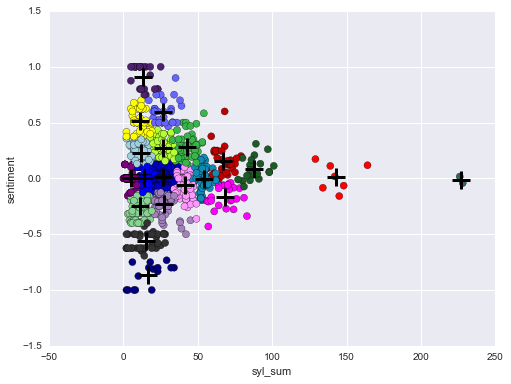

In [34]:
# scatter plot of calories versus alcohol, colored by cluster (0=red, 1=green, 2=blue)
plt.scatter(df_cluster.syl_sum, df_cluster.sentiment, c=colors[df_cluster.cluster], s=50)

# cluster centers, marked by "+"
plt.scatter(centers.syl_sum, centers.sentiment, linewidths=3, marker='+', s=300, c='black')

# add labels
plt.xlabel('syl_sum')
plt.ylabel('sentiment')

Create 3 clusters

In [35]:
df_cluster_3 = df_cluster

In [36]:
df_cluster_3.head()

,0,total_char,syl_sum,sentiment,cluster
0,Down the Rabbit-Hole Alice was beginning to g...,256,83,-0.337778,1
1,So she was considering in her own mind (as wel...,229,70,0.031250,8
2,There was nothing so VERY remarkable in that; ...,109,39,0.650000,16
3,Oh dear!,6,3,0.000000,11
4,I shall be late!',12,4,-0.375000,7


In [47]:
X = df_cluster_3.drop(0, axis=1)

In [48]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [49]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [50]:
df_cluster_3['cluster'] = km.labels_

In [51]:
df_cluster_3.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,42.400971,13.063107,0.007878
1,49.281437,15.089820,0.091732
2,188.530534,57.809160,0.009628


Create 3 Clusters with no syl_sum

In [53]:
df_cluster_no_syl = df_cluster

In [57]:
df_cluster_no_syl.head()

,0,total_char,sentiment,cluster
0,Down the Rabbit-Hole Alice was beginning to g...,256,-0.337778,2
1,So she was considering in her own mind (as wel...,229,0.031250,2
2,There was nothing so VERY remarkable in that; ...,109,0.650000,0
3,Oh dear!,6,0.000000,0
4,I shall be late!',12,-0.375000,0


In [56]:
df_cluster_no_syl = df_cluster.drop('syl_sum', 1)

In [58]:
X = df_cluster_no_syl.drop(0, axis=1)

In [59]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [60]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [61]:
df_cluster_no_syl['cluster'] = km.labels_

In [62]:
df_cluster_no_syl.groupby('cluster').mean()

,total_char,sentiment
cluster,,
0,64.120192,0.460462
1,40.408658,-0.049479
2,188.285171,0.010067


Create 5 Clusters

In [63]:
df_cluster_5 = df_cluster

In [64]:
df_cluster_5.head()

,0,total_char,syl_sum,sentiment,cluster
0,Down the Rabbit-Hole Alice was beginning to g...,256,83,-0.337778,2
1,So she was considering in her own mind (as wel...,229,70,0.031250,2
2,There was nothing so VERY remarkable in that; ...,109,39,0.650000,0
3,Oh dear!,6,3,0.000000,0
4,I shall be late!',12,4,-0.375000,0


In [65]:
X = df_cluster_5.drop(0, axis=1)

In [66]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [67]:
km = KMeans(n_clusters=5, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [68]:
df_cluster_5['cluster'] = km.labels_

In [69]:
df_cluster_5.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,57.882353,17.789216,-0.336462
1,176.541502,54.162055,0.017230
2,36.579545,11.227273,0.014265
3,529.555556,161.666667,0.009813
4,67.083333,20.760417,0.477386


Find ideal amount of clusters for novel

In [ ]:
from sklearn import metrics
metrics.silhouette_score(X_scaled, km.labels_)

In [ ]:
k_range = range(2,150)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X_scaled)
    scores.append(metrics.silhouette_score(X_scaled, km.labels_))

In [ ]:
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silihouette Coefficient')
plt.grid(True)

Find Sentiment Pattern - need to work on this code to make it more universal.

20 pieces

In [70]:
df_novel['total_char'].sum()

109528

In [71]:
ratio = (df_novel['total_char'].sum()/20) - 50

In [74]:
t = 0
x = 0
ratio = (df_novel['total_char'].sum()/20) - 100
def find_this(t, x):
    w = 0    
    sent_stop = []
    while w <= ratio:
        w = df_novel['total_char'][t:x].sum()
        sent_stop.append(x)
        x += 1
    return max(sent_stop)     

In [75]:
t = 0
x = 0
start_point = []
stop_point = []
for n in range(1, 21):
    s = find_this(t, x)
    print "df_novel['total_char'][%s:%s]" %(t, s)
    start_point.append(t)
    stop_point.append(s)
    t = s
    x = s + 1      

df_novel['total_char'][0:60]
df_novel['total_char'][60:115]
df_novel['total_char'][115:192]
df_novel['total_char'][192:264]
df_novel['total_char'][264:352]
df_novel['total_char'][352:443]
df_novel['total_char'][443:505]
df_novel['total_char'][505:586]
df_novel['total_char'][586:655]
df_novel['total_char'][655:741]
df_novel['total_char'][741:843]
df_novel['total_char'][843:938]
df_novel['total_char'][938:1019]
df_novel['total_char'][1019:1078]
df_novel['total_char'][1078:1164]
df_novel['total_char'][1164:1272]
df_novel['total_char'][1272:1363]
df_novel['total_char'][1363:1446]
df_novel['total_char'][1446:1532]
df_novel['total_char'][1532:1623]


In [76]:
twenty_piece_char = []
st = 0
for l in start_point: 
    strt = start_point[st]
    stp = stop_point[st]
    print strt
    print stp
    mn = df_novel['sentiment'][strt:stp].mean()
    twenty_piece_char.append(mn)
    print mn
    st +=1   

0
60
0.0471425918603
60
115
0.0291150727417
115
192
-0.00841434619931
192
264
0.0203819494549
264
352
0.0321346463143
352
443
0.0297514928473
443
505
0.0152957648113
505
586
0.00289304584631
586
655
0.0117530836811
655
741
-0.0366886297918
741
843
0.0155608319717
843
938
0.0100220247589
938
1019
-0.0142449794147
1019
1078
0.0350751126508
1078
1164
0.0387175464501
1164
1272
0.0322697970111
1272
1363
0.0647142857143
1363
1446
0.0876633199465
1446
1532
0.0219613652793
1532
1623
0.0693888452817


In [77]:
n = np.array(n)
twenty_piece_char = np.array(twenty_piece_char)
print twenty_piece_char

[ 0.04714259  0.02911507 -0.00841435  0.02038195  0.03213465  0.02975149
  0.01529576  0.00289305  0.01175308 -0.03668863  0.01556083  0.01002202
 -0.01424498  0.03507511  0.03871755  0.0322698   0.06471429  0.08766332
  0.02196137  0.06938885]


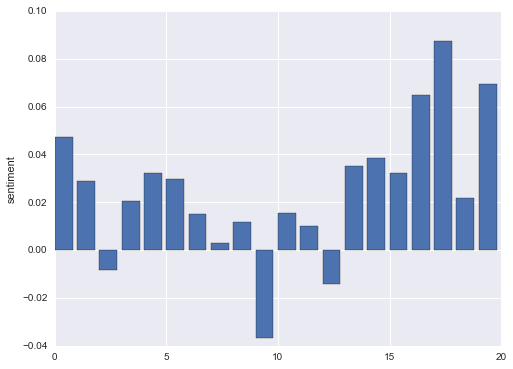

In [78]:
plt.bar(range(20), twenty_piece_char)
plt.ylabel('sentiment')
plt.show()

Create 3 piece sentiment pattern

In [83]:
t = 0
x = 0
ratio = (df_novel['total_char'].sum()/3) -250
def find_this(t, x):
    w = 0    
    sent_stop = []
    while w < ratio:
        w = df_novel['total_char'][t:x].sum()
        sent_stop.append(x)
        x += 1
    return max(sent_stop)  

In [85]:
df_novel.tail()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment
1621,"But her sister sat still just as she left her,...","[3, 3, 6, 3, 5, 4, 2, 3, 4, 3, 7, 3, 4, 2, 3, ...",549,"[1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 3, 1, 2, 1, 1, ...",164,0.117857
1622,The long grass rustled at her feet as the Whit...,"[3, 4, 5, 7, 2, 3, 4, 2, 3, 5, 6, 7, 2, 3, 10,...",516,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, ...",148,-0.065000
1623,"So she sat on, with closed eyes, and half beli...","[2, 3, 3, 2, 4, 6, 4, 3, 4, 8, 7, 2, 10, 6, 3,...",504,"[1, 0, 1, 1, 1, 1, 0, 1, 1, 3, 2, 1, 3, 1, 0, ...",145,-0.158333
1624,"Lastly, she pictured to herself how this same ...","[6, 3, 8, 2, 7, 3, 4, 4, 6, 6, 2, 4, 5, 2, 3, ...",441,"[2, 0, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, ...",129,0.173333
1625,THE END,"[3, 3]",6,"[1, 1]",2,0.000000


need to fix this piece of code

In [84]:
t = 0
x = 0
start_point = []
stop_point = []
for n in range(1, 21):
    s = find_this(t, x)
    print "df_novel['total_char'][%s:%s]" %(t, s)
    start_point.append(t)
    stop_point.append(s)
    t = s
    x = s + 1  

df_novel['total_char'][0:489]
df_novel['total_char'][489:1049]
df_novel['total_char'][1049:1624]


KeyboardInterrupt: 

In [86]:
three_piece_char = []
st = 0
for l in start_point: 
    strt = start_point[st]
    stp = stop_point[st]
    print strt
    print stp
    mn = df_novel['sentiment'][strt:stp].mean()
    three_piece_char.append(mn)
    print mn
    st +=1

0
489
0.0210658632327
489
1049
0.00212585410002
1049
1624
0.0514973242145


In [87]:
n = np.array(n)
three_piece_char = np.array(three_piece_char)
print three_piece_char

[ 0.02106586  0.00212585  0.05149732]


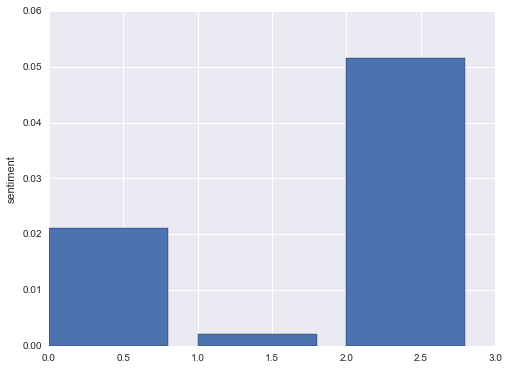

In [88]:
plt.bar(range(3), three_piece_char)
plt.ylabel('sentiment')
plt.show()

Create sentiment pattern based on ideal cluster numbers